<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/notebook_analisis_de_datos_Javi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Este es un notebook para evaluar el comportamiento del Dataset Propuesto por Javi. El codigo esta devidido en varias celdas para facilitarsu ejecucion

-*- coding: utf-8 -*-
"""JaviFlight.ipynb



Original file is located at
    https://colab.research.google.com/drive/1Ldgzwa2PnJqDL6X1eQfWXoSxvDNhTE1t

Objetivo:
Predecir si un vuelo sufrirá retraso (≥15 min) usando únicamente información
disponible antes del despegue.

Tipo de problema:
Clasificación binaria (0 = no retraso, 1 = retraso).

Dataset:
Vuelos comerciales en EE.UU. (2019–2023)

"
"""


In [1]:
#Importo el dataset

import kagglehub

path = kagglehub.dataset_download(
    "patrickzel/flight-delay-and-cancellation-dataset-2019-2023"
)

print("Dataset path:", path)

#Exploro archivos

import os

os.listdir(path)

#Tamaño real del csv

import pandas as pd


csv_path = f"{path}/flights_sample_3m.csv"


num_columnas = pd.read_csv(csv_path, nrows=0).shape[1]
num_filas = sum(1 for _ in open(csv_path, encoding="utf-8")) - 1


print(f"Filas reales del CSV: {num_filas}")
print(f"Columnas reales del CSV: {num_columnas}")

#Cargo muestra dataframe de 100k

import pandas as pd

df = pd.read_csv(
    f"{path}/flights_sample_3m.csv",
    nrows=100_000
)

df.shape

#Columnas

df.columns


100%|██████████| 140M/140M [00:01<00:00, 126MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023/versions/7
Filas reales del CSV: 3000000
Columnas reales del CSV: 32


Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

In [2]:
#Creo varible temporal hour y variable objetivo delayed, evitamos leakage (información no disponible cuando se hace la predicción).
#Hora programada y no real y 15 minutos.

df["hour"] = df["CRS_DEP_TIME"] // 100   #nos quedamos con las horas
df["delayed"] = (df["DEP_DELAY"] >= 15).astype(int)  #y la hacemos binaria

print("Delay rate:", df["delayed"].mean()) #binaria: la media representa la propabilidad de delay

#Prueba binaria

df["delayed"].unique()

#Retraso por hora del día, agrupo hour y delayed y gráfica. Quiero saber si hay diferencias de probabilidad y si tienen realismo.

hour_delay = (
df.groupby("hour")["delayed"]   #la media del binario por grupo se interpreta como probabilidad.
.mean()
.sort_index()
)
print(hour_delay)


Delay rate: 0.17664
hour
0     0.232323
1     0.229508
2     0.346154
3     0.100000
4     0.000000
5     0.073412
6     0.071768
7     0.088135
8     0.103715
9     0.124329
10    0.145850
11    0.157565
12    0.165072
13    0.190789
14    0.201580
15    0.209918
16    0.216464
17    0.223878
18    0.245970
19    0.263841
20    0.263342
21    0.282587
22    0.251613
23    0.213439
Name: delayed, dtype: float64


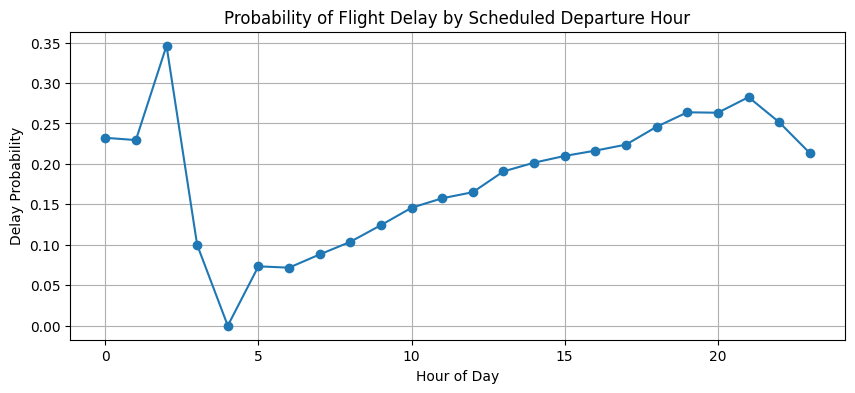

distance_bin
(28.999, 331.0]     0.152890
(331.0, 546.0]      0.160376
(546.0, 813.0]      0.177791
(813.0, 1154.0]     0.200040
(1154.0, 5095.0]    0.192238
Name: delayed, dtype: float64


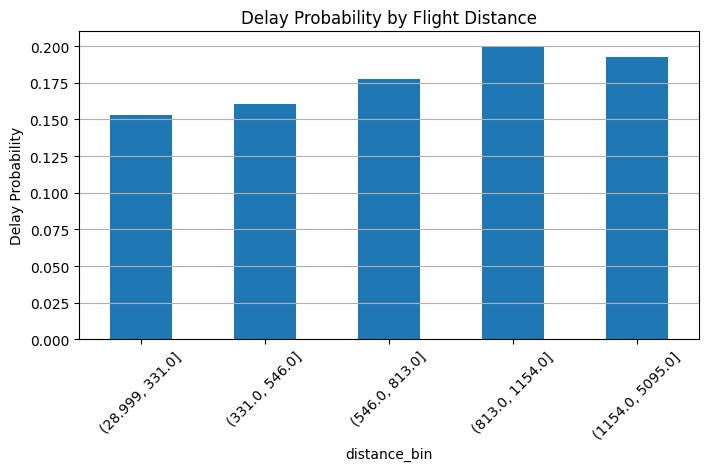

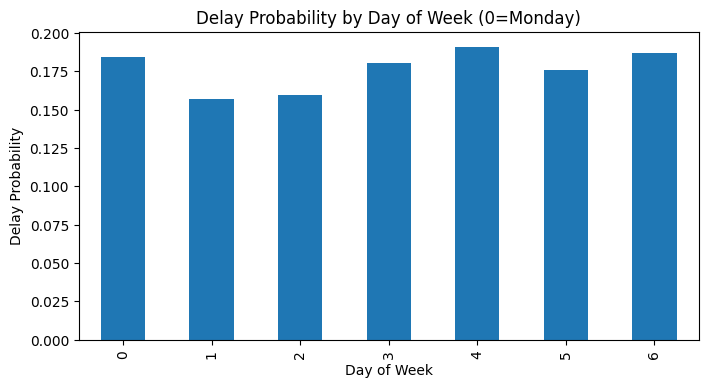

AIRLINE
JetBlue Airways                       0.268089
Frontier Airlines Inc.                0.257521
Allegiant Air                         0.227979
Southwest Airlines Co.                0.219502
Spirit Air Lines                      0.218142
American Airlines Inc.                0.184887
United Air Lines Inc.                 0.178609
ExpressJet Airlines LLC d/b/a aha!    0.175824
Mesa Airlines Inc.                    0.168004
Horizon Air                           0.161189
Name: delayed, dtype: float64


In [3]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,4))
hour_delay.plot(kind="line", marker="o")
plt.title("Probability of Flight Delay by Scheduled Departure Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Delay Probability")
plt.grid(True)
plt.show()

#Retraso x distancia (rango de millas) y gráfica

df["distance_bin"] = pd.qcut(df["DISTANCE"], q=5)


distance_delay = (
df.groupby("distance_bin", observed=True)["delayed"]
.mean()
)
print(distance_delay)


plt.figure(figsize=(8,4))
distance_delay.plot(kind="bar")
plt.title("Delay Probability by Flight Distance")
plt.ylabel("Delay Probability")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

#Creo día de la semana

df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])
df["day_of_week"] = df["FL_DATE"].dt.dayofweek

#Retraso por día de la semana

dow_delay = (
    df.groupby("day_of_week")["delayed"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(8,4))
dow_delay.plot(kind="bar")
plt.title("Delay Probability by Day of Week (0=Monday)")
plt.xlabel("Day of Week")
plt.ylabel("Delay Probability")
plt.show()

#top 10 aerolíneas


airline_delay = (
df.groupby("AIRLINE")["delayed"]
.mean()
.sort_values(ascending=False)
.head(10)
)
print(airline_delay)

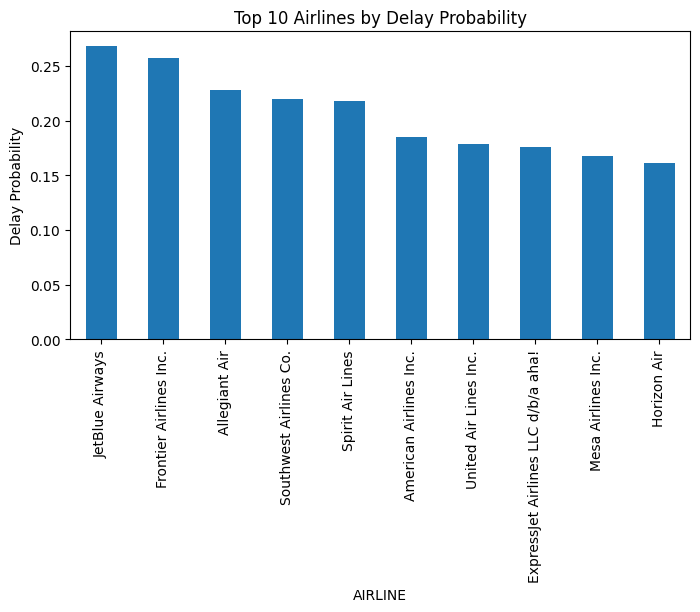

Morning delay prob: 0.114
Night delay prob: 0.258
Difference: 0.145


0.08168772635113504

In [4]:
plt.figure(figsize=(8,4))
airline_delay.plot(kind="bar")
plt.title("Top 10 Airlines by Delay Probability")
plt.ylabel("Delay Probability")
plt.show()

df["delayed"].value_counts(normalize=True) #Variable objetiva binaria prueba

# 82.34% NO se retrasan, 17.66% SI se retrasan

# Comparar mañana vs noche
morning = df[df["hour"].between(6, 11)]["delayed"].mean()
night = df[df["hour"].between(18, 23)]["delayed"].mean()

print("Morning delay prob:", round(morning, 3))
print("Night delay prob:", round(night, 3))
print("Difference:", round(night - morning, 3))

hour_delay = (
    df.groupby("hour")["delayed"]
    .mean()
)

hour_delay.std()

# Este criterio mide cuánto cambia la probabilidad de retraso a lo largo del día;
# si la variación es alta, significa que la hora del vuelo influye de forma real
# en los retrasos, y el ratio entre datasets nos permite comparar cuál captura
# mejor ese patrón temporal sin necesidad de entrenar ni optimizar modelos.

# Al medir la variación de la probabilidad de retraso según la hora, verificamos
# que la hora del vuelo tiene impacto real, y usando el ratio podemos decidir
# qué dataset conserva mejor esa señal predictiva sin incurrir en mayor coste
# computacional.

#-Contiene un gran volumen de datos reales.

#-Incluye variables temporales y operativas conocidas antes del vuelo.

#-Permite definir una variable objetivo clara siguiendo estándares de aviación  (vuelo retrasado si la salida es ≥ 15 minutos).

#-Presenta suficiente detalle para análisis por hora, distancia,aerolínea y día de la semana.

#Durante el preprocesamiento se evitó explícitamente el uso de variables que introducen data leakage (información no disponible cuando se hace la predicción),
#garantizando que los análisis y los posibles modelos predictivos sean válidos, realistas y reproducibles.